# Google CTF 2018 Quals - Wired CSV \[Misc, 220p, 42 solver\]
## _by !SpamAndHex_

'Wired CSV' is clearly a hardware challenge: we were given a photo of some electronic device wired to a logic analyzator and the measurement data from the logic analyzator in CSV format.

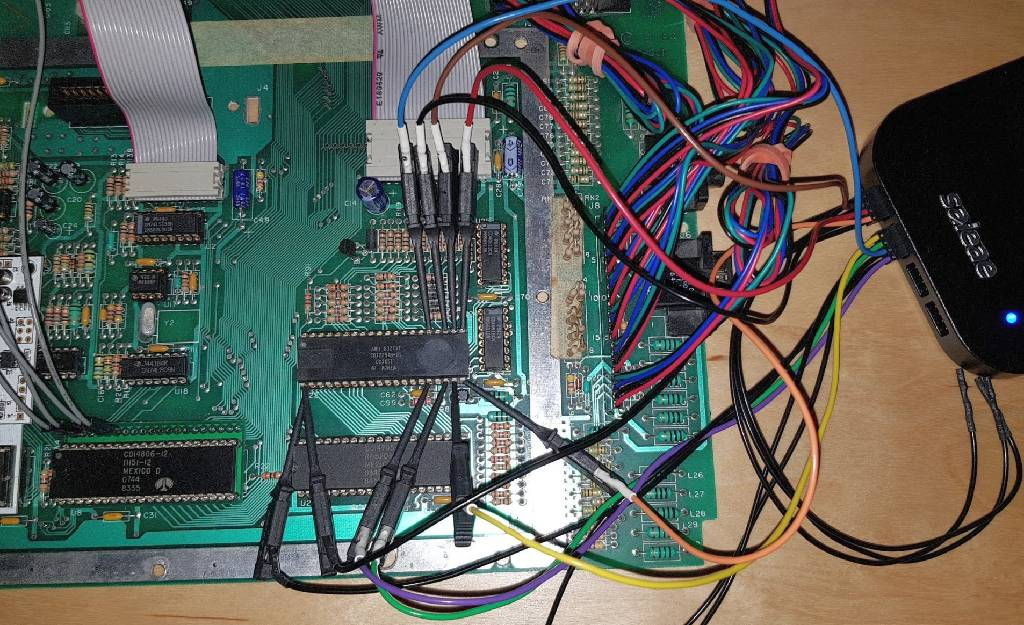

First of all we have to identify the device under measurement. The top of the chip reads 'CO12294B' and after a little searching on the internet it is sure that this board is a part of an Atari computer. According to [ https://www.atarimax.com/jindroush.atari.org/achip.html ] the chip belong to a 1200xl, 800xl or 600xl version Atari. Further searching for each of them, on a forum [ http://atariage.com/forums/topic/170558-help-atari-800xl/ ] a very similar voard can be seen (slight difference is the main CPU, which is seems to have been prepared at the given one).

Fortunately for those, old devices it is very easy to find a huge range of scaned documents. The most useful among the manuals is the "Service Manual" [ http://www.atarimania.com/documents/Atari_800XL_Sams_Computerfacts_Technical_Service.pdf ]. We can witness many form of this manual, but those all contained a schematic of the PCB! (Unfortunately providing the schematic with the device is unimaginable for today device :( )
The service manual describes the chip we are interested in: it is a POKEY chip, which is responsible for reading the keyboard input and outputing audio. Here is the pinout for the chip (taken from here: [ http://www.atarimania.com/documents/atari_800XL_Field_Service_manual.pdf ]):

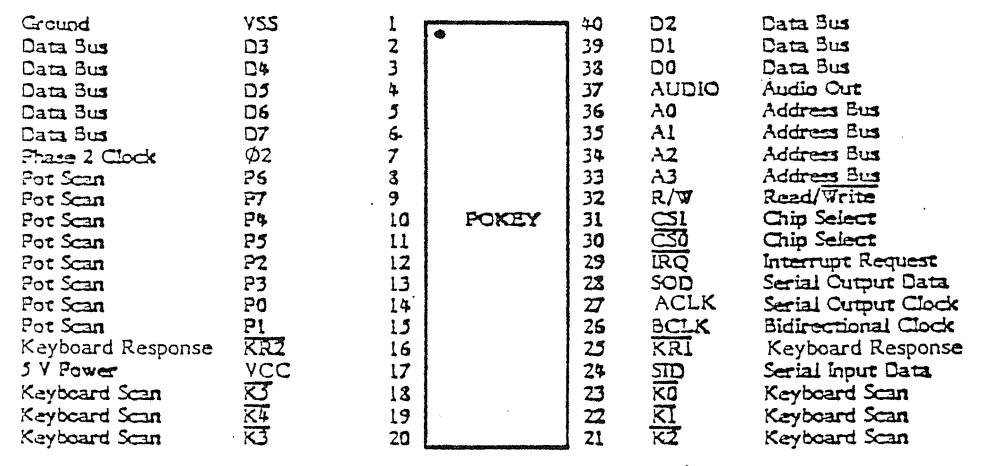

From this diagram we can clearly see that the wired pins are K0 to K5, KR0 and KR1 and of course the ground. Following the wires from the PCB to the logic analyzer the channel order is also K0-K5, KR0-1.

So we found the chip and the pinout as well, but how it works? For this the schematics included to the service manual was a huge help for us. The following is the relevant section of the hardware, neccessary to understand the reading of the keyboard.

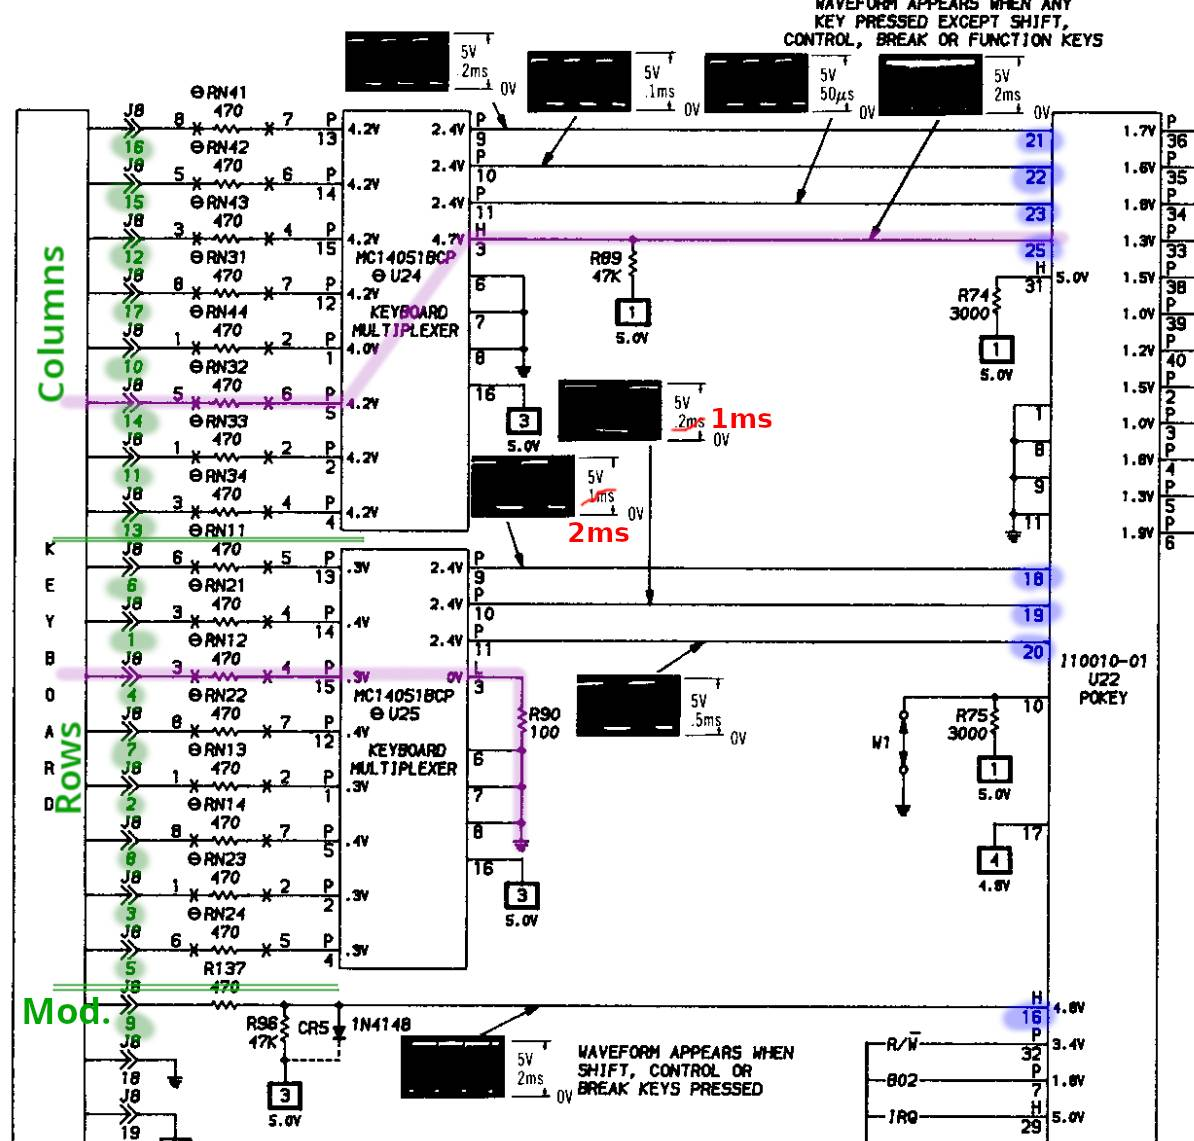

On the right there is the POKEY chip with the relevant pins marked blue. Those pins connects to two CD4051 [ http://www.ti.com/lit/ds/symlink/cd4051b.pdf ] analog multiplexer. And the multiplexers are connected to the keyboard scan matrix.

An analog multiplexer is a digitally controllable switch, depending on the 3 bit value of {9,10,11} it selects one of its pins from {1,2,4,5,12,13,14,15} and "wires" that onto the 3rd pin. The current flow is bidirectional, so it can be more-or-less modelled as a switch.

There are two of those analog multiplexers: the common pin of the lower chip is tied to the ground and the common pin of the upper one is wired to KR1. The 8 channels are connected to row/column drivers of the a keyboard matrix. The keyboard matrix column drivers are all pulled up, but when the lower multiplexer selects a column it "drives" with GND instead of 5V. Thus when the upper multiplexer "reads out" a row, it can detect a the zero, as a pressed key. The POKEY knows which is the currently read key, because it controlls the multiplexer selectors. The POKEY drivers the selector as those two 3bit values were togother a 6 bit counter, where the lower chip has a MSB part. (Note, that the service manual has a typo: pin 18(K5) has the 2ms pulse width and pin 19(K4) has the 1ms)

The only good diagram on the keyboard matrix wiring can be found at [ http://members.casema.nl/hhaydn/howel/logic/burched/b5_800xl_kbd.htm ] .Still it orderes the wires by pin count, where ordering by multiplex selectors would be much more unterstandable! So here is the reordered image which corresponds to the multiplexer connections (and thus the adjacent rows/columns are really has teh difference of 1).

On the upper diagram with purpule the current path is noted in case of pressing the 'E' key.

The modifier keys can be read via the KR2 port, and changes its value by the upper half of the 6bit K0-5 counter.

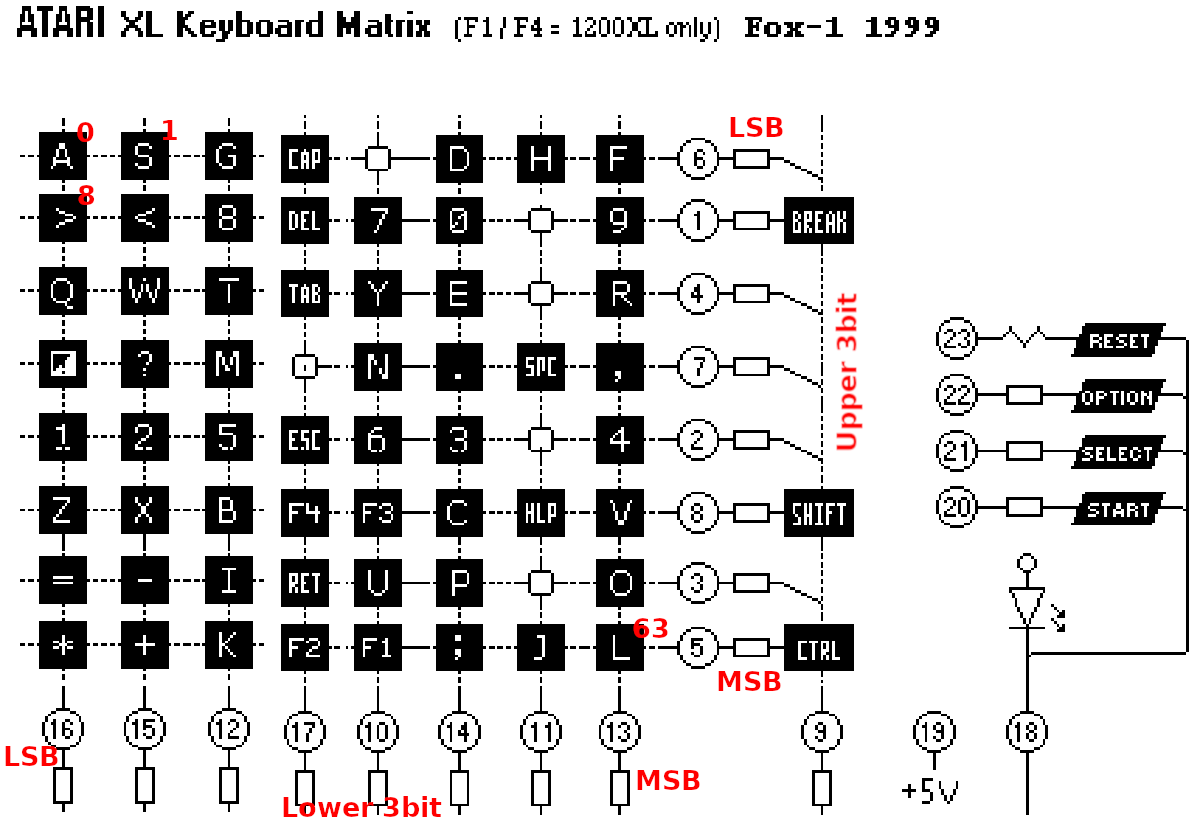

So now, understanding the underlying hardware working, let's turn to the measurement CSV file. Probably it was recorded with the Saleae Logic Analyzator and exported to CSV format, but unfortunately the same program cannot import from CSV... We attempted to process it in python.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
plt.style.use("seaborn-whitegrid")
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from bisect import bisect_left

Import the data and rename those unmanageable column names

In [2]:
dat = pd.read_csv(
    'data.csv',
    names=['ta','a6','a7','t0','d0','t1','d1','t2','d2','t3','d3','t4','d4','t5','d5','t6','d6','t7','d7'],
    delimiter=",",
    skipinitialspace=True,
    skiprows=1,
)

In the imported data the columns don't have equal height, create simple scipy arrays from the continuous data (drop N/A fields)

In [3]:
t, d = [], []
for i in range(8):
    t.append(sp.array(list(dat["t" + str(i)].dropna())))
    d.append(sp.array(list(dat["d" + str(i)].dropna())))
t.append(sp.array(list(dat["ta"].dropna())))
t.append(sp.array(list(dat["ta"].dropna())))
d.append(sp.array(list(dat["a6"].dropna())))
d.append(sp.array(list(dat["a7"].dropna())))
del dat # free up some memory

For managing the waveform, let's create a helper function which can plot the waveform in time domain. The measurement contained the data in delta-format: only the time of changes are saved for the digital data, analog data has evenly sampled values.

In [4]:
def plot_analizator(a=0.0, b=0.01, title=""):
    ax, subplots = plt.subplots(10, 1, figsize=(20, 10))
    if title:
        ax.suptitle(title)
    ax.subplots_adjust(hspace=0)
    
    for i in range(10):
        if i < 8:
            # digital signals
            subplots[i].step(
                # +-1 to have the at least 3 points to be able to connect them through the graph
                t[i][bisect_left(t[i], a)-1:bisect_left(t[i], b)+1],
                d[i][bisect_left(t[i], a)-1:bisect_left(t[i], b)+1],
                where='post',
            )
            subplots[i].axis(xmin=a, xmax=b, ymin=-0.1, ymax=1.1)
        else:
            # analog signals
            subplots[i].plot(
                # +-1 to have the at least 3 points to be able to connect them through the graph
                t[i][bisect_left(t[i], a)-1:bisect_left(t[i], b)+1],
                d[i][bisect_left(t[i], a)-1:bisect_left(t[i], b)+1],
                '.-',
            )
            subplots[i].axis(xmin=a, xmax=b, ymin=-0.1, ymax=5.1)
            
        subplots[i].set_yticks([])
        if i != 9:
            subplots[i].xaxis.set_ticklabels([])
        else:
            subplots[i].xaxis.get_major_formatter().set_useOffset(False)
        if (i < 6):
            subplots[i].set_ylabel("K%d"%i)
        else:
            subplots[i].set_ylabel("KR%d"%(((i-6)&1)+1))


Now let's validate the information what we could gather so far based on the excellent service manuals:
 - K0-5 are indeed act like a counter (even though there is some offset between the changes)
 - KR1 and 2 are low active and remains low during a K0 pulse-width time

Because the logic analyzator only saved the change of the signal, and the data is binary, thus it is enough to take every two samples offsetted by one to always sample the low signal values on the KR1 and 2 pins.

In [5]:
@interact(n=(0, len(t[7][1::2])-1, 1))
def nth_press_key(n):
    t_press = t[7][1::2][n]
    plot_analizator(t_press-0.001, t_press+0.002, title="The %dth key press of a modifier key" % n)

interactive(children=(IntSlider(value=2, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

Unfortuantely there are some glithes in the digital and in the analog waveform as well. There are some spikes, occuring only for the durration of a sample time (which probably was 10MSps). But there are other, little longer signal, which not sustain its value for the whole K0 pulse durration: that is the bouncing of the keyboards.

In [6]:
@interact(n=(0, len(t[6][2::1])-1, 1), dt=(0.0001,0.01,0.0005))
def nth_press_key(n, dt):
    t_press = t[6][2::1][n]
    plot_analizator(t_press-dt/5, t_press+dt*4/5, title="The %dth key press of a letter" % n)

interactive(children=(IntSlider(value=248, description='n', max=496), FloatSlider(value=0.004600000000000001, …

Those glithes must be filtered! The most simple filtering method is the pulse-width based filtering. For this we have to compute the corrent pulse-width and somehow have to separate from the glithes. Using a histogram of the adjacent edges it can be easily seen that most of the pulses are around 65usec, but also there are a few around 40usec and the clearly glithes are below 20usec. Let's use 30usec as a separator: any pulse below 30usec will be removed.

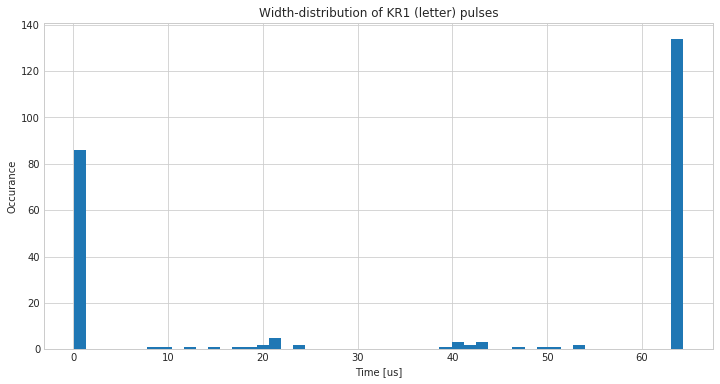

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Width-distribution of KR1 (letter) pulses")
plt.ylabel("Occurance")
plt.xlabel("Time [us]")
plt.hist(sp.diff(t[6])[1::2]*1e6, bins=50);

In [8]:
# so a pulse must be longer than 30usec
def get_filtered_KR1(t, t_threashold=30e-6):
    diffs_ok = sp.diff(t)[1::2] > t_threashold
    return sp.array([t[2*i+1] for i, isok in enumerate(diffs_ok) if isok])
t_filt = get_filtered_KR1(t[6])

Now we can move on to the actual key decode phase. Firstly a table must be created for the keyscan codes. This array is constructed based on the previous keyboard matrix wiring. The shifted key (when SHIFT is pressed) is also included.

In [9]:
keyscans = [
      'a', 's', 'g', '<CAP>', '<NC>', 'd',     'h', 'f',
      '>', '<', '8', '<DEL>',    '7', '0',  '<NC>', '9',
      'q', 'w', 't', '<TAB>',    'y', 'e',  '<NC>', 'r',
  '<???>', '?', 'm',  '<NC>',    'n', '.',     ' ', ',',
      '1', '2', '5', '<ESC>',    '6', '3',  '<NC>', '4',
      'z', 'x', 'b',  '<F4>', '<F3>', 'c', '<HLP>', 'v',
      '=', '-', 'i', '<RET>',    'u', 'p',  '<NC>', 'o',
      '*', '+', 'k',  '<F2>', '<F1>', ';',     'j', 'l'
]

keyscans_shift = [
      'A',  'S', 'G', '<CAP>', '<NC>', 'D',     'H', 'F',
      '>',  '<', '@', '<DEL>',    '?', ')',  '<NC>', '(',
      'Q',  'W', 'T', '<TAB>',    'Y', 'E',  '<NC>', 'R',
  '<???>',  '?', 'M',  '<NC>',    'N', ']',     ' ', '[',
      '!',  '"', '%', '<ESC>',    '&', '#',  '<NC>', '$',
      'Z',  'X', 'B',  '<F4>', '<F3>', 'C', '<HLP>', 'V',
      '|',  '_', 'I', '<RET>',    'U', 'P',  '<NC>', 'O',
      '^', '\\', 'K',  '<F2>', '<F1>', ':',     'J', 'L'
]

And finally the phase of decoding the keys!

As there is a little offset among K0-5 and between KR1, let's not rely on the K0-5 numbers (or mindig with the correction of those values)! Instead let's replace K0-5 entirelly by a 6bit counter. This counter is "clocked" by the edge changes on K0 and has an initial value. So the K0-5 value is known at any time, just count up until that time the K0 changes (which is the index of the current time) and add the initial value, finally take a modulo 64 opetarion. This time the time->index mapping is solved by a bisection search on the array of time values.

So going over the filtered 1->0 change of KR1 we can get the sensed key(s). The modifier keys can also be sensed, comparing the timestamp of the closest modkey press-down with the current letter press-down: if they are very close, the modifier was pressed for the letter key.

A very dump key repeation blocking algoritm was also implemented to avoid the repetatedly sensed keys (and fortunately flag doesn't have repeatated letter in it).

In [10]:
# first value is 0, and bisect search will gave 1 for t=0, so substract 1 in advance
initial_val = int(sum([d[i][0]*(1<<i) for i in range(6)]))-1
old_char = '\x00'

for t_keypress in t_filt:
    scancode = (initial_val+bisect_left(t[0], t_keypress)) & 0x3f
    modkey_near_time = t[7][1::2][min(bisect_left(t[7][1::2], t_keypress), len(t[7][1::2])-1)]
    
    if sp.absolute(modkey_near_time - t_keypress) < 1e-1:
        modkey = ((initial_val+bisect_left(t[0], modkey_near_time)) & 0x3f) >> 3
        if modkey == 5: # Shift
            curr_char = keyscans_shift[scancode]
        else:
            curr_char = '<MOD???>'
    else:
        curr_char = keyscans[scancode]
        
    if curr_char != old_char:
        print(old_char, end='')
    old_char = curr_char

 flag: 8-bit-hardware-keyloger

So finally we here is the flag!